In [ ]:
import tensorflow as tf
from maptd_model import maptd_model
from IPython import display
import os
from shutil import rmtree
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from tkinter.filedialog import askdirectory

from pipeline_v2 import get_dataset, get_dataset_from_txt_files
from losses import total_loss
import stats

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
    tar_score = tf.keras.layers.Input(shape=[128, 128, 1], name='target_score_map')
    tar_geo = tf.keras.layers.Input(shape=[128, 128, 5], name='target_geo_map')

    x = tf.keras.layers.concatenate([inp, tar_score, tar_geo])  

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)  
    down4 = downsample(512, 4)(down3) 

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar_score, tar_geo], outputs=last)

In [ ]:
LAMBDA = 1
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, score_map, gen_score_map, geo_map, 
                   gen_geo_map, training_mask):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    loss = total_loss(score_map, gen_score_map, geo_map, gen_geo_map, training_mask)

    total_gen_loss = gan_loss + LAMBDA * loss

    return total_gen_loss, gan_loss, loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
def show_score_map(tile, gt_score_map, pred_score_map, threshold=None):
    pred_score_map = np.where(pred_score_map > threshold, 1, 0)
    COLORMAP = 'gray'
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(np.squeeze(tf.cast(tile, tf.uint8)))
    ax[1].imshow(np.squeeze(gt_score_map), cmap=COLORMAP)
    ax[2].imshow(np.squeeze(pred_score_map), cmap=COLORMAP)
    plt.show()

In [ ]:
class StepDecayLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    """
    def __init__(self, initial_learning_rate, decay_rate, decay_every_n_steps):
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.decay_every_n_steps = decay_every_n_steps
    
    def __call__(self, step):
        exp = tf.floor(step/self.decay_every_n_steps)
        return self.initial_learning_rate * tf.pow(self.decay_rate, exp)
    """
    def __init__(self, initial_learning_rate, decay_rate, decay_on_step):
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.decay_on_step = decay_on_step
        
    def __call__(self, step):
        new_lr = tf.cond(step < self.decay_on_step, 
                       lambda: self.initial_learning_rate,
                       lambda: self.initial_learning_rate * self.decay_rate)
        return new_lr

In [ ]:
dataset_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/general_dataset/'
INITIAL_DIR = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/ckpts/models'

conf_file_dir = askdirectory(initialdir=INITIAL_DIR, title='Select the directory '
    'with the configuration files')

best_model_dir = os.path.join(conf_file_dir, 'best_gan')
print(conf_file_dir)

In [ ]:
# Create log files
log_dir = os.path.join(conf_file_dir, 'gan_logs')
sum_writer = tf.summary.create_file_writer(os.path.join(
    log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [ ]:
# Define the models
generator = maptd_model()
discriminator = Discriminator()

# Define the optimizers
step_to_reduce_lr=2**17
initial_lr = 1e-4
decay_rate = 0.1
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=StepDecayLRSchedule(initial_lr, 
                                      decay_rate,
                                      step_to_reduce_lr), epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Initialize checkpoints
ckpt_dir = os.path.join(conf_file_dir, 'gan_ckpts')
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           generator=generator,
                           discriminator=discriminator)

#### Run the commands in the following cell if you want to continue from a checkpoint

In [ ]:
########################
ckpt = tf.train.Checkpoint(generator=generator)
###############################NOTE: Check this!
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)
ckpt.restore(latest)

#### VALIDATION PROCESSES (TODO: CHANGE THE TITLE)

In [ ]:
valid_impath = '/media/gerasimos/Νέος τόμος/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/general_dataset/images/D0006-0285025.tiff'
jsonpath = '/media/gerasimos/Νέος τόμος/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/general_dataset/json/D0006-0285025.json'

def validate(valid_impath, jsonpath):
    # NOTE: Currently works for one image
    """
    Calculates the Average Precicion for the validation image
    """
    from predict_w_loc_args import predict_v2
    from data_tools import parse_boxes_from_json
    
    base = os.path.splitext(os.path.basename(valid_impath))[0]
    prediction = {}
    prediction[base] = predict_v2(generator, valid_impath)

    [_,gt_polys,gt_labels] = parse_boxes_from_json(jsonpath)
    ground_truth = {}
    ground_truth[base] = {
        'polygons' : gt_polys,
        'labels': gt_labels
    }
    
    sample_stats, _ = stats.evaluate_predictions(ground_truth, prediction,
                                                 match_labels=False,
                                                 iou_match_thresh=0.5)
    return sample_stats[base]['ap'] 

In [ ]:
@tf.function
def train_step(generator, discriminator, tile, 
               score_map, geo_map, training_mask, 
               step, summary_writer):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_score_map, gen_geo_map = generator(tile, training=True)
        
        resized_input_image = tile[:, ::4, ::4, :]
        
        disc_real_output = discriminator([resized_input_image, score_map, 
                                          geo_map], training=True)
        
        disc_generated_output = discriminator([resized_input_image, 
                                               gen_score_map, gen_geo_map], 
                                              training=True)

        gen_total_loss, gen_gan_loss, gen_loss = generator_loss(
            disc_generated_output, score_map, gen_score_map, geo_map, 
            gen_geo_map, training_mask)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_loss', gen_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(generator, discriminator, train_dataset, test_dataset, summary_writer,
        total_steps=2**20, enumerate_from=0):
    average_precision = 0
    training_start = time.time()
    start = training_start
    for step, (tile, score_map, geo_map, training_mask) in \
                train_dataset.repeat().take(total_steps - enumerate_from).\
                enumerate(start=enumerate_from):
        
        train_step(generator, discriminator, tile,
               score_map, geo_map, training_mask, 
               step, summary_writer)
        
        step = step.numpy()
        
        if (step + 1) % 500 == 0:
            display.clear_output(wait=True)
            print(datetime.datetime.now().strftime("%H:%M:%S"))            
            print(f'Step {step + 1}/{total_steps}')
            
            if step != 0 and step != enumerate_from:
                print(f'Time taken for the last 500 steps: '
                      f'{time.time()-start:.2f} sec')
                estimated_remaining_time = int((time.time() - training_start) / \
                    (step - enumerate_from) * (total_steps - step))
                print(f'Estimated time for the training to finish: '
                      f'{estimated_remaining_time // 3600} hrs, '
                      f'{int(estimated_remaining_time % 3600 / 60)} mins')
            
            print('Current Learning Rate: ', generator_optimizer.lr(step))
            
            example_tile, example_score_map, _, _ = next(iter(test_dataset.take(1)))
            example_pred_score_map, _ = generator(example_tile, training=True)
            show_score_map(example_tile, 
                           example_score_map, 
                           example_pred_score_map, 
                           threshold=0.8)    
            
            start = time.time()
            
        # Save the model if the validation image improves the average precision
        # (best model)
        if (step + 1) % 1000 == 0:
            new_average_precision = validate(valid_impath, jsonpath)
            if new_average_precision > average_precision:
                generator.save(os.path.join(conf_file_dir, 'best_gan'))
                print(f'Old AP = {average_precision}, new AP = '
                      f'{new_average_precision}. A new best model was saved at '
                      f'step{step + 1}.')
                
                rmtree(best_model_dir)
                os.mkdir(best_model_dir)
                with open(os.path.join(best_model_dir, 'best_model_step.txt'), 
                          'w') as f:
                    f.write(f'Best model saved at step: {step + 1}')   
                
                
                average_precision = new_average_precision
            
        if (step + 1) % 10000 == 0:
            ckpt.save(file_prefix=ckpt_prefix)
            print(f'Checkpoint at step: {step + 1}')

In [ ]:
TRAIN_BATCH_SIZE = 8
# Load the dataset generators
train_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'train', 
                                      batch_size=TRAIN_BATCH_SIZE)
test_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'test', 
                                     batch_size=1)

13:46:46
Step 1000/1048576
Time taken for the last 500 steps: 65.78 sec
Estimated time for the training to finish: 42 hrs, 30 mins
Current Learning Rate:  0.0001


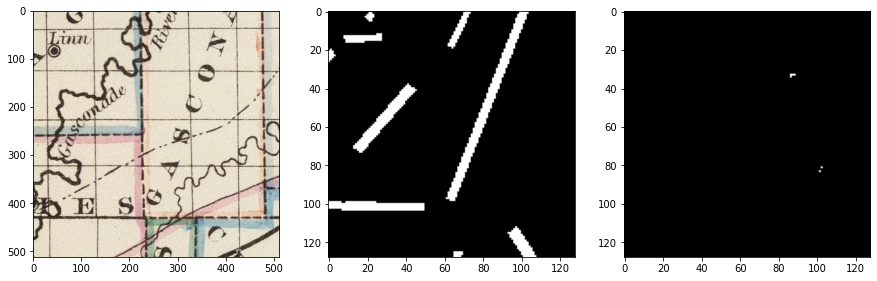

ModuleNotFoundError: No module named 'lanms'

In [16]:
fit(generator, discriminator, train_ds, test_ds, sum_writer)